## Visualize and Compare Salary Distribution of Ontario Government Top Companies in Each Sector
### - Data Source from Ontario Sunshine List 2022 
<img src="thesunshinelist.jpg" width="250" height="200">

Import Libary

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

Load Data

In [153]:
# load the source data from Ontario.ca
url = "https://www.ontario.ca/public-sector-salary-disclosure/pssd-assets/files/2022/tbs-pssd-compendium-salary-disclosed-2022-en-utf-8-2023-03-24.csv"
df_raw = pd.read_csv(url)

In [154]:
df_raw.head()

,Sector,Last Name,First Name,Salary,Benefits,Employer,Job Title,Year
0,Colleges,Whitaker,Christopher,552946.10,64388.76,Humber College Institute Of Technology and Adv...,President,2022
1,Colleges,Morrison,Janet,459810.99,11340.95,Sheridan College Institute Of Technology and A...,President and Vice Chancellor,2022
2,Colleges,Sado,Anne,454202.32,412.56,George Brown College Of Applied Arts and Techn...,"President, Emeritus",2022
3,Colleges,Agnew,David,422065.42,18299.46,Seneca College Of Applied Arts and Technology,President,2022
4,Colleges,Tibbits,John,409900.00,923.07,Conestoga College Institute Of Technology and ...,President,2022


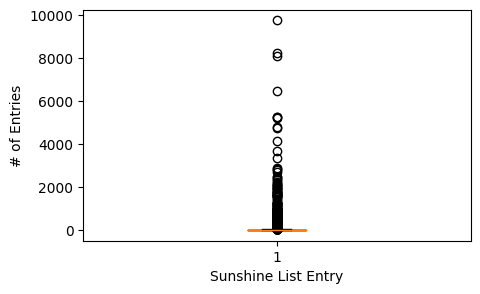

In [155]:
# remove "seconded" companies which is temporary from the sunshine list
df_raw = df_raw[df_raw.apply(lambda x: 'seconded' not in x['Sector'].lower(),1)]

# count how many people each company entered the sunshine list in 2022
df_company_entrycount = df_raw.groupby('Employer')['Salary'].count().sort_values(ascending=False).reset_index()

# draw a box plot to help filter out the minorities
fig = plt.figure(figsize =(5, 3))
plt.boxplot(df_company_entrycount['Salary'].values)
plt.xlabel("Sunshine List Entry")
plt.ylabel("# of Entries")
plt.show()

It looks like most of the sunshine list population is occupied by the few top companies, let's check.

In [156]:
ratio = 0.9 # set a ratio to test the portion

# Sunshine list total people
Total1 = df_raw.shape[0]
print('There are {} people in total entered sunshine list in 2022, and {}% of that is {}.'.format(Total1, 
                                                                                                  ratio*100, 
                                                                                                  int(Total1*ratio)))
# Sunshine list total company
Total2 = df_company_entrycount.shape[0]
print('There are {} companies in total entered sunshine list in 2022.'.format(Total2))

####
df_company_entrycount['cumsum'] = df_company_entrycount['Salary'].cumsum()
df_company_topperc = df_company_entrycount[df_company_entrycount['cumsum']<=Total1*ratio]
print("The top {} companies from all the {} companies, which is only {}%, account for {}% of the entire population in the sunshine list.".format(df_company_topperc.index[-1],
                                                                                                                                         Total2,
                                                                                                                                         round(df_company_topperc.index[-1]/Total2*100,2),
                                                                                                                                         ratio*100))

# obtain a list of the top majority companies
majority_companies = df_company_topperc['Employer'].values

There are 266770 people in total entered sunshine list in 2022, and 90.0% of that is 240093.
There are 2232 companies in total entered sunshine list in 2022.
The top 236 companies from all the 2232 companies, which is only 10.57%, account for 90.0% of the entire population in the sunshine list.


So, 10.5% of the companies account for 90% of all the entries in the sunshine list, which is even more extreme than the "20-80" law.

### Consolidate Sectors
- Some sectors need to be combined, such as Government of Ontario subs
- All Ontario Power Generation sectors will change to "Crown Agencies"

In [157]:
def sector_change(x):
    if 'Government of Ontario' in x:
        return 'Government of Ontario'
    elif 'Ontario Power Generation' in x:
        return 'Crown Agencies'
    else:
        return x
    
df_raw = df_raw.rename(columns = {'Sector':'Sector_Original'}) 
df_raw['Sector'] = df_raw['Sector_Original'].apply(lambda x: sector_change(x))

### Find Top N Companies in Each Sector
- Omit 'Seconded' sector which is temporary
- Only picked the top companies that account for the 90% of the sunshine list population
- Ranked based on the average salary

In [158]:
df_raw

,Sector_Original,Last Name,First Name,Salary,Benefits,Employer,Job Title,Year,Sector
0,Colleges,Whitaker,Christopher,552946.10,64388.76,Humber College Institute Of Technology and Adv...,President,2022,Colleges
1,Colleges,Morrison,Janet,459810.99,11340.95,Sheridan College Institute Of Technology and A...,President and Vice Chancellor,2022,Colleges
2,Colleges,Sado,Anne,454202.32,412.56,George Brown College Of Applied Arts and Techn...,"President, Emeritus",2022,Colleges
3,Colleges,Agnew,David,422065.42,18299.46,Seneca College Of Applied Arts and Technology,President,2022,Colleges
4,Colleges,Tibbits,John,409900.00,923.07,Conestoga College Institute Of Technology and ...,President,2022,Colleges
...,...,...,...,...,...,...,...,...,...
266898,Universities,De Fazio,Arin,100008.68,208.08,University Of Toronto,Business Officer,2022,Universities
266899,Universities,Cadieux,Michelle,100007.92,246.67,McMaster University,Instructional Assistant / Sessional Faculty,2022,Universities
266900,Universities,Critoph,Elise,100006.96,0.00,University Of Ottawa,Professeur(e) adjoint(e) / Assistant Professor,2022,Universities
266901,Universities,Marsh,Jeffrey,100000.08,0.00,Laurentian University Of Sudbury,Associé(e) de recherche / Research Associate,2022,Universities


In [160]:
# filter the top 10% companies that account for 90% of the sunshine list population
df_majority = df_raw[df_raw['Employer'].isin(majority_companies)]

# rank partitions 
df_top_company = df_majority.groupby(['Sector','Employer'])['Salary'].mean().reset_index().sort_values(['Sector','Salary'], ascending= False).reset_index(drop = True)
df_top_company['Rank'] = df_top_company.groupby('Sector').cumcount()+1

# take out top N in each sector
N=7
df_top_company = df_top_company[df_top_company['Rank']<=N]

In [161]:
df_top_company.head(50)

,Sector,Employer,Salary,Rank
0,Universities,McMaster University,166822.142135,1
1,Universities,Queen’s University,164340.277778,2
2,Universities,University Of Toronto,164150.478942,3
3,Universities,University Of Western Ontario,162056.389025,4
4,Universities,York University,162009.121341,5
5,Universities,Brock University,161613.305000,6
6,Universities,University Of Waterloo,160125.714246,7
19,School Boards,Conseil Scolaire Catholique Franco-Nord,111707.577616,1
20,School Boards,Huron-Superior Catholic District School Board,111251.266057,2
21,School Boards,Hastings And Prince Edward District School Board,110984.748144,3


### Visualize Top N Companys' Salary Distribution in Each Sector

In [163]:
colors = sns.color_palette(palette=None, n_colors=N).as_hex()

# sector = ['Universities']

for sector in df_top_company['Sector'].unique():
    df_companies = df_top_company[df_top_company['Sector']==sector]
    companies = df_companies['Employer'].values
    df_sample = df_raw[df_raw['Employer'].isin(companies)]
    df_sample = df_sample.merge(df_companies[['Employer','Rank']], on = 'Employer', how = 'left')
    df_sample = df_sample[['Employer','Salary','Rank']].sort_values(['Rank','Salary'])

    X = df_sample['Employer'].unique()
    X = X[::-1] # reverse the list to show the highest one at the top
    Y = [df_sample[df_sample['Employer']==i]['Salary'].values for i in X]

    fig = go.Figure()
    for xd, yd, cls in zip(X, Y, colors):
        fig.add_trace(go.Box(
            x=yd,
            name=xd,
            boxpoints='all', # whether to show all points or other choices
            jitter=0.6, # sample points width relative to the box width
            boxmean = True,
            whiskerwidth=0.3,
            fillcolor=cls,
            marker_size=1.2,
            line_width=1.5,
            pointpos =0, # sample points location relative to the box [-2,2]
            width = 0.6, # box width
            notched=True, # wether to display a notch for the median
            )
        )

    fig.update_layout(
        title='Employee Salaries over $100k of the Top {} Company in the "{}" Sector'.format(N,sector),
        autosize=False,
        width=1000,
        height=int(500*(1+(N-5)/5)), # the height is normalized to N=5, and will dynamically adjust based on N size
        # yaxis=dict(
        #     autorange=True,
        #     showgrid=True,
        #     zeroline=True,
        #     dtick=5,
        #     gridcolor='rgb(255, 255, 255)',
        #     gridwidth=1,
        #     zerolinecolor='rgb(255, 255, 255)',
        #     zerolinewidth=2,
        # ),
        # margin=dict(

        #     l=40,
        #     r=30,
        #     b=80,
        #     t=100,
        # ),
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=False
    )

    fig.show()

# to do
1. add hover to show position info
2. think of how to solve x range issue